# Phishing URL Detection

### Initialisation

In [1]:
import pandas as pd
df = pd.read_csv('dataset.csv')
df.sample(5)

,URL,Label
88341,www.dummysoftware.com/clockdummy.html,good
129412,shakti.sunaarise.com/admin/session/file_doc.ph...,bad
384735,mapquest.com/maps?city=North+Lima&state=OH,good
453325,tvdome.eu/tv-shows/une-grenade-avec-a,good
121672,thelmachan.com.br/images/banners/a607b0c8e7c98...,bad


### Description

In [2]:
df.describe()

,URL,Label
count,549346,549346
unique,507195,2
top,jhomitevd2abj3fk.tor2web.org/,good
freq,52,392924


### Remove Duplicates

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(507196, 2)

### Remove Missing Values

In [4]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

### Dataset Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507196 entries, 0 to 516470
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     507196 non-null  object
 1   Label   507196 non-null  object
dtypes: object(2)
memory usage: 11.6+ MB


### Dataset Subset

In [6]:
df = df.sample(200000, random_state=42)

### Preprocessing

In [7]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = PorterStemmer()

def tokenize(sentence):
    tokens = tokenizer.tokenize(sentence)
    for token in tokens:
        token = stemmer.stem(token)
    return " ".join(tokens).strip()

df['URL_preprocessed'] = df['URL'].apply(tokenize)
df.head()

,URL,Label,URL_preprocessed
506546,tr7.datahost84.org/rrca.php?id=,bad,tr datahost org rrca php id
128881,samyinayeh.com/login.htm,bad,samyinayeh com login htm
38800,paypal.us.cgi.bin.webscr.cmd.login.webapps.mpp...,bad,paypal us cgi bin webscr cmd login webapps mpp...
17623,phoenixafrica.biz/wp-content/themes/twentyelev...,bad,phoenixafrica biz wp content themes twentyelev...
62284,www.techbomb.com/websafe/,good,www techbomb com websafe


### Vectorizing

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
vectorizer = TfidfVectorizer(max_features=12000,stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['URL_preprocessed'])
Y = df['Label']
Y.replace({'bad':0,'good':1},inplace=True)

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_17888\2852462016.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y.replace({'bad':0,'good':1},inplace=True)


### Model Preparation

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Model Performance - Multinomial Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
model = MultinomialNB()
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      9083
           1       0.95      0.99      0.97     30917

    accuracy                           0.95     40000
   macro avg       0.95      0.91      0.93     40000
weighted avg       0.95      0.95      0.95     40000



### Model Performance - Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      9083
           1       0.95      0.99      0.97     30917

    accuracy                           0.95     40000
   macro avg       0.95      0.91      0.93     40000
weighted avg       0.95      0.95      0.95     40000



### Model Performance - XGBoost

In [12]:
from xgboost import XGBClassifier
model = XGBClassifier()
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.69      0.80      9083
           1       0.92      0.99      0.95     30917

    accuracy                           0.92     40000
   macro avg       0.94      0.84      0.88     40000
weighted avg       0.93      0.92      0.92     40000



### Model Performance - Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      9083
           1       0.95      0.97      0.96     30917

    accuracy                           0.94     40000
   macro avg       0.93      0.90      0.91     40000
weighted avg       0.94      0.94      0.94     40000



### Model Performance - ANN

In [14]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1, mode='auto', min_delta=0.0001)
X_train = X_train.astype('float32')

model = Sequential()
model.add(Dense(128, input_dim=12000, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train.toarray(), Y_train, epochs=5, batch_size=64, callbacks=[callback], validation_split=0.2)




Epoch 1/5


2000/2000 [==============================] - 100s 49ms/step - loss: 0.2376 - accuracy: 0.9046 - val_loss: 0.1352 - val_accuracy: 0.9513
Epoch 2/5
2000/2000 [==============================] - 73s 36ms/step - loss: 0.1162 - accuracy: 0.9578 - val_loss: 0.1179 - val_accuracy: 0.9547
Epoch 3/5
2000/2000 [==============================] - 85s 42ms/step - loss: 0.1028 - accuracy: 0.9623 - val_loss: 0.1160 - val_accuracy: 0.9579
Epoch 4/5
2000/2000 [==============================] - 76s 38ms/step - loss: 0.0969 - accuracy: 0.9649 - val_loss: 0.1155 - val_accuracy: 0.9576
Epoch 5/5
2000/2000 [==============================] - 70s 35ms/step - loss: 0.0936 - accuracy: 0.9663 - val_loss: 0.1174 - val_accuracy: 0.9577


In [15]:
from sklearn.metrics import classification_report,accuracy_score
Y_prob = model.predict(X_test.toarray())
Y_pred = (Y_prob > 0.5).astype(int)
print('Accuracy Score: ',accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

1250/1250 [==============================] - 6s 4ms/step
Accuracy Score:  0.9597
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      9083
           1       0.96      0.98      0.97     30917

    accuracy                           0.96     40000
   macro avg       0.95      0.93      0.94     40000
weighted avg       0.96      0.96      0.96     40000



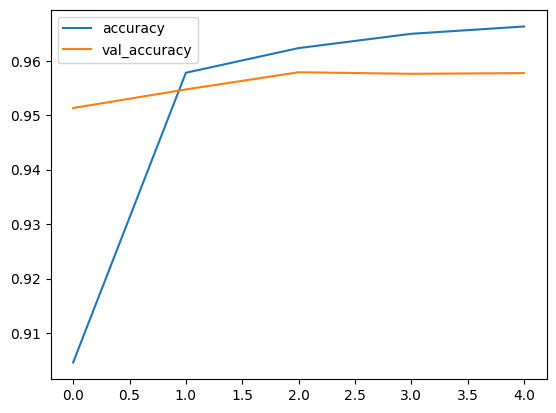

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='best')
plt.show()

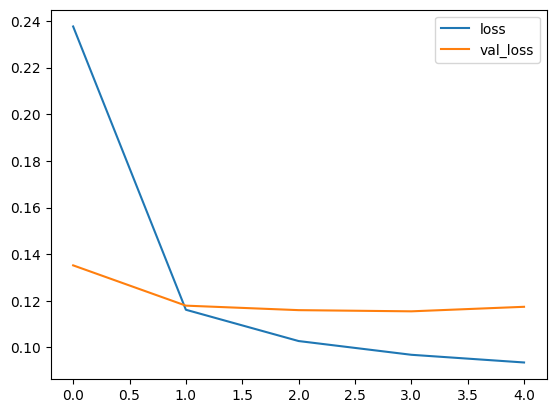

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'],loc='best')
plt.show()

### Confusion Matrix

<Axes: >

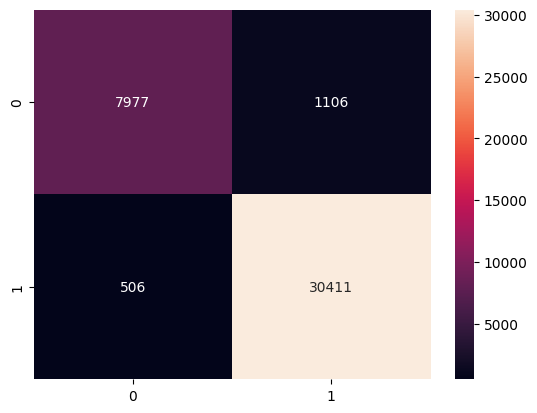

In [21]:
from tensorflow.math import confusion_matrix
import seaborn as sns
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d')

### User Prediction

In [43]:
import numpy as np
url = input("Enter the URL: ")
url_token = tokenize(url)
url_vectorized = vectorizer.transform([url_token])
url_prob = model.predict(url_vectorized.toarray())
url_pred = np.where(url_prob > 0.6, 0, 1)
if url_pred == 0:
    print("Bad URL")
else:
    print("Good URL")
url_prob

# amazingdeals!!**.com
# ClickHereForDiscount.com

1/1 [==============================] - 0s 37ms/step
Bad URL


array([[0.87313807]], dtype=float32)

### Pickling

In [19]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)